Section 1: Generative networks 1: variational autoencoders and MNIST characters (20 mins)

- Video 1: Normal autoencoders
- Video 2: Applying autoencoders
- Video 3: Adding the "variational part" of a VAE
- Video 4: Practical use of your autoencoder: noise removal


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 

from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

mnist = input_data.read_data_sets('datasets/MNIST_data', one_hot=True)

## Video 2: Applying autoencoders 

There are some uses for autoencoders. One of them is the removal of noise in images. If you have an image with noise as input and pass it through an autoencoder your decoded images is noise-free!

It can also serve as a compression mechanism. You compress input images into a lower dimensional space, and can use this lower dimensional space as input for other algorithms. This way the autoencoder can serve as a first step in an unsupervised algorithm. Note that during the compressing and expanding we never used the labels, the neural network learned everything himself. This sparse-autoencoder is useful as pre-training, even for normal classification tasks!


## Video 3: variational autoencoder

There is a really good blog about variational autoencoders. Please [take a look at it](http://kvfrans.com/variational-autoencoders-explained/). 
You can even use an autoencoder to generate new images. By feeding values in the middle of your network your network will generate a new image. However: we don't know what range of values we can feed, and what this will result in. 

Although you can already do that right now, you get the best results using a so-called variational autoencoder. In that case we add an additional constraint to our neural network: the center layer has to follow a so-called "unit gaussian distribution". After we did this we can simply sample values from the same distribution, and we know this will result in a good looking image!


Great explanation of Kullback Leibler divergence using space worms analogy: https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained


In [23]:


tf.reset_default_graph()

num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = 28

batch_size = 100
n_z = 10

x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

# Encode
# x -> z_mean, z_sigma -> z
f1 = fc(x, 512, activation_fn=tf.nn.relu)
f2 = fc(f1, 384, activation_fn=tf.nn.relu)
f3 = fc(f2, 256, activation_fn=tf.nn.relu)

# Z part
z_mu = fc(f3, n_z, activation_fn=None)
z_log_sigma_sq = fc(f3, n_z, activation_fn=None)
eps = tf.random_normal(shape=tf.shape(z_log_sigma_sq),mean=0, stddev=1, dtype=tf.float32)
z = z_mu + tf.sqrt(tf.exp(z_log_sigma_sq)) * eps

# Decode
# z -> x_hat
g1 = fc(z, 256, activation_fn=tf.nn.relu)
g2 = fc(g1, 384, activation_fn=tf.nn.relu)
g3 = fc(g2, 512, activation_fn=tf.nn.relu)
x_hat = fc(g3, input_dim, activation_fn=tf.sigmoid)

# Loss
# Reconstruction loss
# Minimize the cross-entropy loss
# H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
epsilon = 1e-10
recon_loss = -tf.reduce_sum(x * tf.log(epsilon+x_hat) + (1-x) * tf.log(epsilon+1-x_hat), axis=1)
recon_loss = tf.reduce_mean(recon_loss)

# Latent loss
# Kullback Leibler divergence: measure the difference between two distributions
# Here we measure the divergence between the latent distribution and N(0, 1)
latent_loss = -0.5 * tf.reduce_sum(
    1 + z_log_sigma_sq - tf.square(z_mu) - tf.exp(z_log_sigma_sq), axis=1)
latent_loss = tf.reduce_mean(latent_loss)

total_loss = tf.reduce_mean(recon_loss + latent_loss)
train_op = tf.train.AdamOptimizer().minimize(total_loss)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [24]:

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

num_epoch = 30
for epoch in range(num_epoch):
    for iter in range(num_sample // batch_size):

        batch = mnist.train.next_batch(batch_size)
        _, loss, res_recon_loss, res_latent_loss = sess.run([train_op, total_loss, recon_loss, latent_loss],
                                                     feed_dict={x: batch[0]})
    print("Hoi")
    print("Loss: %f recon loss: %f latent loss: %f " % (loss, res_recon_loss, res_latent_loss))

assert res_recon_loss < 100
assert loss < 105

Hoi
Loss: 137.007111 recon loss: 125.041359 latent loss: 11.965755 
Hoi
Loss: 129.527679 recon loss: 115.971893 latent loss: 13.555789 
Hoi
Loss: 125.362976 recon loss: 111.266945 latent loss: 14.096033 
Hoi
Loss: 114.191551 recon loss: 99.966492 latent loss: 14.225061 
Hoi
Loss: 112.970184 recon loss: 97.820847 latent loss: 15.149339 
Hoi
Loss: 116.865906 recon loss: 102.474792 latent loss: 14.391113 
Hoi
Loss: 108.767479 recon loss: 94.485390 latent loss: 14.282090 
Hoi
Loss: 111.118980 recon loss: 96.180344 latent loss: 14.938637 
Hoi
Loss: 105.754517 recon loss: 91.179199 latent loss: 14.575320 
Hoi
Loss: 105.381409 recon loss: 90.579933 latent loss: 14.801472 
Hoi
Loss: 102.078461 recon loss: 87.054024 latent loss: 15.024433 
Hoi
Loss: 105.446030 recon loss: 90.612679 latent loss: 14.833352 
Hoi
Loss: 104.642181 recon loss: 89.369003 latent loss: 15.273180 
Hoi
Loss: 107.591293 recon loss: 92.302246 latent loss: 15.289046 
Hoi
Loss: 106.710991 recon loss: 91.414795 latent loss: 15

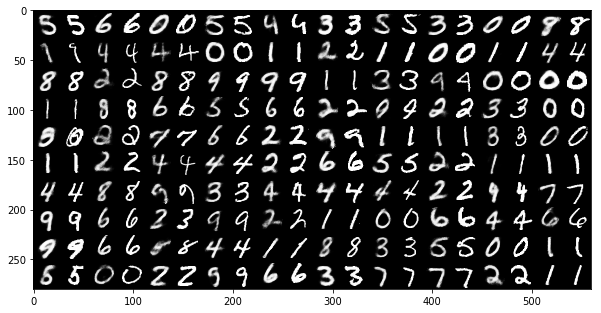

In [16]:
x_reconstructed = sess.run(x_hat, feed_dict={x: batch[0]})


n = np.sqrt(100).astype(np.int32)
I_reconstructed = np.empty((h*n, 2*w*n))
for i in range(n):
    for j in range(n):
        blaatje = np.concatenate(
            (x_reconstructed[i*n+j, :].reshape(h, w), 
             batch[0][i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = blaatje

plt.figure(figsize=(10, 20))
plt.imshow(I_reconstructed, cmap='gray')



# Section 2: Generative networks (20 mins)

## Video 1: Building the "adversarial detector" 
## Video 2: Generating new images with an adversarial generator
## Video 3: Training both networks: a min-max game
## Video 4: Improving your GAN: Wasserstein GANs 


Extracting datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


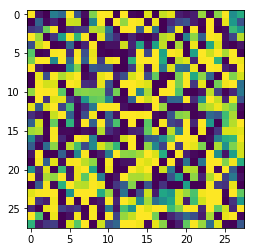

generator_loss:3.576803, decoder_loss:0.459250


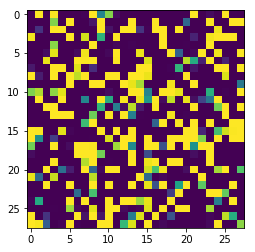

generator_loss:1.834917, decoder_loss:0.179585


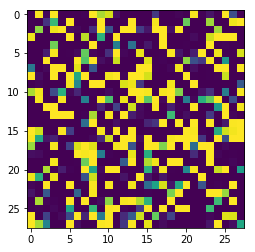

generator_loss:1.836191, decoder_loss:0.179921


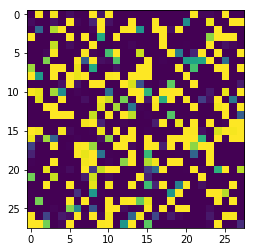

generator_loss:1.827207, decoder_loss:0.180533


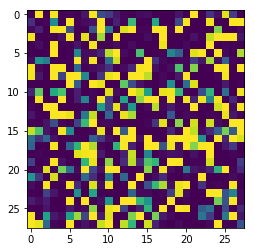

generator_loss:1.829766, decoder_loss:0.179286


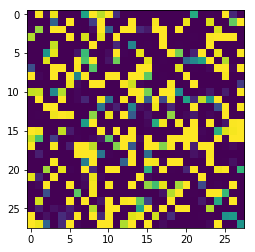

generator_loss:1.828956, decoder_loss:0.181799


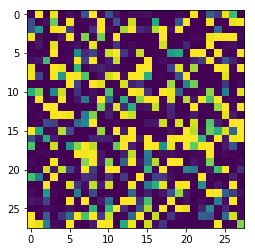

generator_loss:1.828246, decoder_loss:0.177923


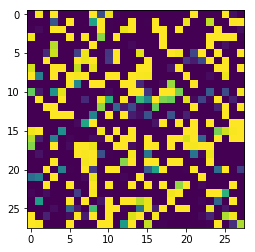

generator_loss:1.828190, decoder_loss:0.177628


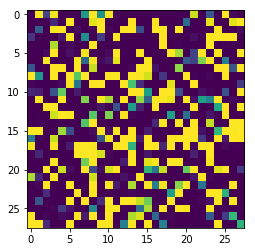

generator_loss:1.826488, decoder_loss:0.178188


KeyboardInterrupt: 

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

data = input_data.read_data_sets("datasets/MNIST_data")
batch_size = 64

'''
  Helper functions for network
'''
def binarize(img):
    return (np.random.uniform(size=img.shape) < img).astype(np.float32)
def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1))
def get_bias(shape):
    return tf.Variable(tf.constant(shape=shape, value=0.1))

def generator(g_input):
    with tf.name_scope('G'):
        l1_size, l2_size = 1200, 1200
        g_w1 = get_weights([28*28, l1_size])
        g_b1 = get_bias([l1_size])
        g_w2 = get_weights([l1_size, l2_size])
        g_b2 = get_bias([l2_size])
        g_w3 = get_weights([l2_size, 28*28])
        g_b3 = get_bias([28*28])

        l1 = tf.nn.relu(tf.add(tf.matmul(X, g_w1), g_b1))
        l2 = tf.nn.relu(tf.add(tf.matmul(l1, g_w2), g_b2))
        logits = tf.sigmoid(tf.add(tf.matmul(l2, g_w3), g_b3))
        return logits
    
class Discriminator():
    def __init__(self):
        with tf.name_scope('D'):
            d_l1_size, d_l2_size = 500, 100
            self.d_w1 = get_weights([28*28, d_l1_size])
            self.d_b1 = get_bias([d_l1_size])
            self.d_w2 = get_weights([d_l1_size, d_l2_size])
            self.d_b2 = get_bias([d_l2_size])
            self.d_w3 = get_weights([d_l2_size, 1])
            self.d_b3 = get_bias([1])

    def network(self, d_input):
        d_l1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(d_input, self.d_w1), self.d_b1)), 0.5)
        d_l2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(d_l1, self.d_w2), self.d_b2)), 0.5)
        pred = tf.sigmoid(tf.add(tf.matmul(d_l2, self.d_w3), self.d_b3))
        return pred

X = tf.placeholder(shape=[None, 28*28], dtype=tf.float32)
Z = tf.placeholder(shape=[None, 28*28], dtype=tf.float32)

g_z = generator(Z)
decoder = Discriminator()
d_x = decoder.network(X)
d_z = decoder.network(g_z)

g_batch = tf.Variable(0)
d_batch = tf.Variable(0)

g_loss = - tf.reduce_mean(tf.reduce_sum(tf.log(d_z), reduction_indices=[1]))
g_learning_rate = tf.train.exponential_decay(0.01, g_batch, 100, 0.95, staircase=True)
g_optimizer = tf.train.MomentumOptimizer(g_learning_rate, 0.9).minimize(g_loss)

d_loss = - tf.reduce_mean(tf.reduce_sum(tf.log(d_x) + tf.log(1-d_z), reduction_indices=[1]))
d_learning_rate = tf.train.exponential_decay(0.01, g_batch, 100, 0.95, staircase=True)
d_optimizer = tf.train.MomentumOptimizer(d_learning_rate, 0.9).minimize(d_loss)

epochs = 10000
k = 5

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        for j in range(k):
            # NOTE using an arbitary distribution as noise
            batch_z = np.random.normal(0, 0.1, (batch_size,28*28))
            batch_x = binarize(data.train.next_batch(batch_size)[0])
            _, d_l = sess.run([d_optimizer, d_loss], feed_dict={X:batch_x, Z:batch_z})
            
        batch_z = np.random.normal(0, 0.1, batch_size*28*28).reshape((batch_size, 28*28))
        batch_x = data.train.next_batch(batch_size)[0]
        _t, g_l = sess.run([g_optimizer, g_loss], feed_dict={X:batch_x, Z:batch_z})
        if i%100 ==0:

            results = sess.run(g_z, feed_dict={X:batch_x, Z:batch_z})
            plt.imshow(np.reshape(results[0],(28,28)))
            plt.show()
            print("generator_loss:%f, decoder_loss:%f"%(g_l, d_l))
 


Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Summary name raw image is illegal; using raw_image instead.
INFO:tensorflow:Summary name generated image is illegal; using generated_image instead.


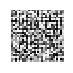

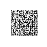

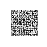

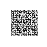

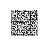

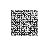

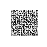

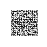

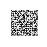

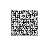

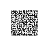

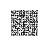

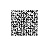

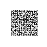

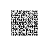

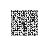

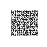

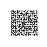

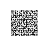

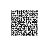

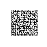

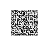

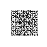

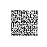

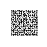

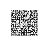

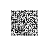

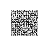

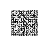

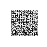

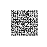

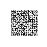

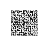

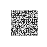

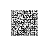

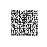

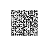

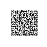

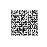

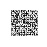

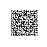

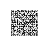

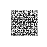

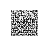

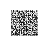

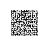

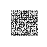

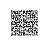

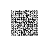

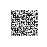

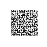

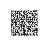

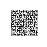

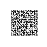

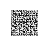

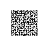

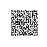

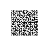

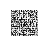

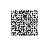

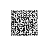

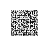

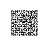

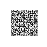

epoch:0 g_loss:11.511286 d_loss:6.947315
epoch:100 g_loss:27.200764 d_loss:0.236381
epoch:200 g_loss:27.648315 d_loss:0.238227
epoch:300 g_loss:23.505444 d_loss:0.040839
epoch:400 g_loss:22.121721 d_loss:0.008077


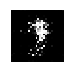

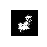

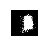

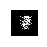

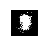

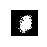

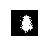

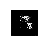

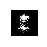

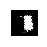

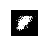

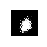

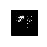

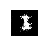

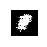

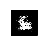

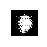

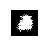

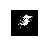

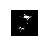

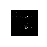

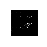

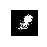

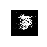

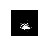

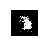

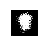

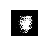

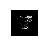

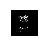

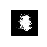

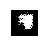

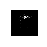

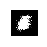

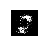

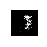

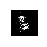

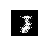

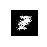

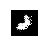

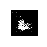

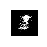

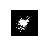

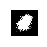

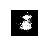

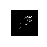

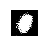

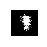

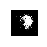

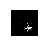

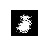

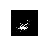

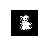

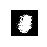

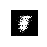

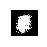

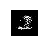

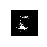

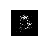

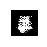

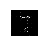

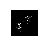

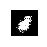

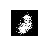

epoch:500 g_loss:12.974054 d_loss:0.427499
epoch:600 g_loss:11.495095 d_loss:0.131682
epoch:700 g_loss:9.204683 d_loss:0.218865
epoch:800 g_loss:10.163593 d_loss:0.105831
epoch:900 g_loss:11.419977 d_loss:0.260105


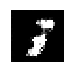

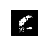

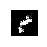

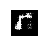

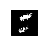

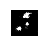

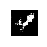

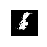

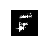

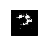

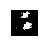

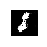

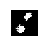

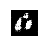

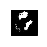

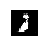

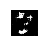

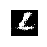

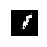

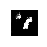

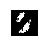

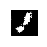

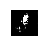

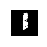

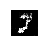

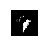

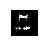

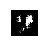

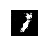

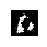

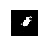

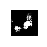

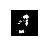

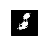

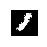

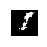

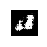

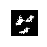

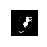

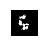

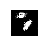

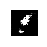

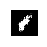

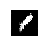

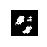

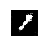

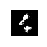

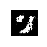

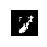

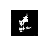

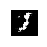

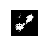

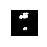

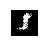

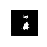

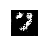

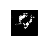

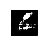

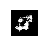

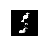

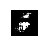

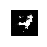

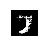

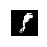

epoch:1000 g_loss:9.400057 d_loss:0.068569
epoch:1100 g_loss:8.188409 d_loss:0.139161
epoch:1200 g_loss:5.696365 d_loss:0.258045
epoch:1300 g_loss:7.314785 d_loss:0.386241
epoch:1400 g_loss:7.431336 d_loss:0.102746


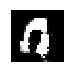

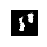

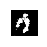

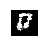

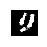

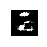

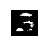

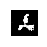

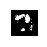

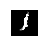

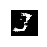

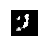

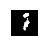

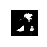

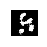

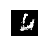

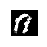

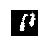

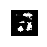

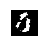

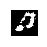

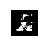

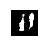

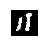

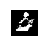

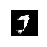

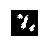

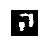

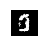

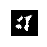

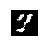

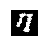

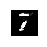

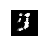

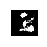

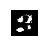

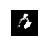

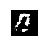

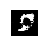

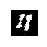

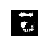

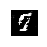

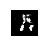

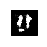

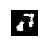

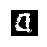

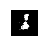

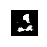

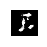

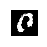

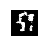

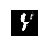

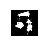

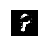

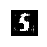

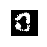

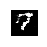

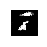

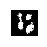

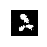

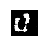

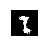

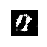

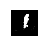

epoch:1500 g_loss:5.083596 d_loss:0.442297
epoch:1600 g_loss:7.928928 d_loss:0.196981
epoch:1700 g_loss:4.835673 d_loss:0.053423
epoch:1800 g_loss:3.091551 d_loss:0.148086
epoch:1900 g_loss:8.834837 d_loss:0.163290


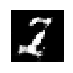

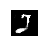

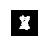

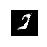

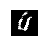

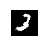

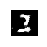

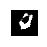

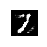

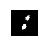

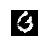

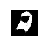

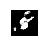

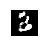

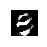

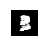

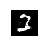

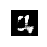

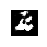

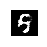

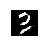

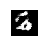

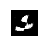

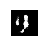

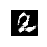

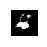

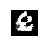

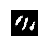

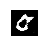

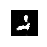

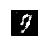

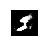

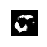

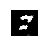

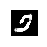

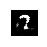

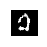

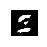

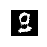

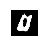

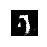

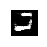

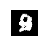

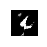

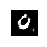

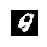

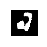

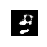

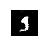

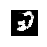

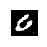

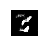

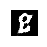

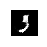

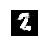

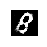

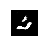

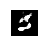

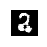

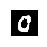

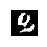

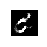

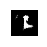

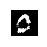

epoch:2000 g_loss:2.449481 d_loss:0.319462
epoch:2100 g_loss:5.612683 d_loss:0.371184
epoch:2200 g_loss:3.453319 d_loss:0.511837
epoch:2300 g_loss:5.290752 d_loss:0.392420
epoch:2400 g_loss:3.186795 d_loss:0.795514


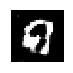

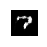

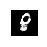

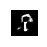

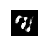

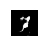

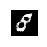

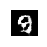

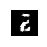

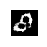

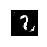

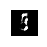

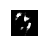

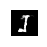

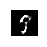

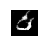

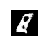

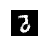

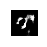

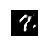

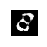

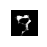

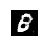

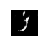

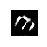

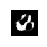

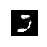

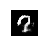

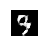

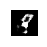

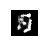

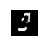

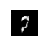

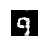

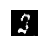

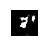

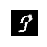

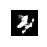

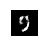

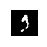

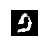

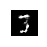

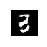

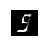

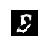

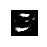

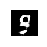

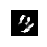

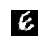

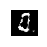

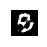

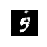

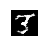

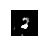

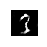

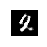

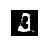

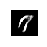

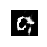

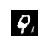

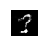

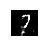

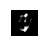

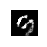

epoch:2500 g_loss:4.451293 d_loss:0.448392
epoch:2600 g_loss:5.503364 d_loss:0.482808
epoch:2700 g_loss:2.931566 d_loss:0.922246
epoch:2800 g_loss:3.465296 d_loss:0.536365
epoch:2900 g_loss:5.288564 d_loss:0.748407


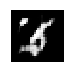

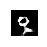

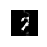

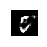

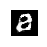

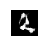

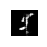

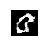

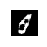

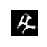

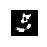

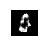

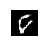

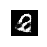

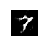

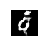

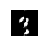

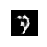

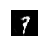

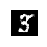

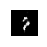

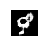

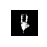

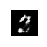

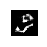

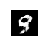

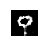

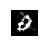

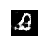

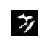

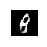

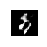

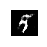

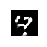

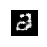

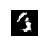

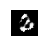

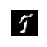

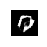

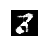

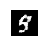

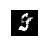

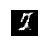

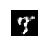

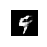

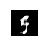

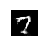

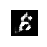

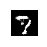

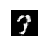

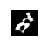

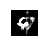

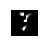

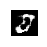

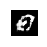

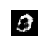

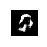

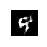

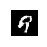

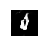

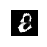

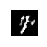

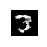

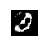

epoch:3000 g_loss:3.944037 d_loss:0.242360
epoch:3100 g_loss:2.226389 d_loss:0.621485
epoch:3200 g_loss:4.727852 d_loss:0.246484
epoch:3300 g_loss:2.484684 d_loss:0.699821
epoch:3400 g_loss:2.972935 d_loss:0.443946


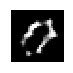

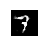

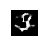

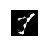

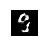

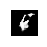

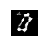

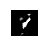

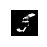

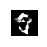

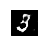

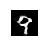

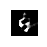

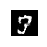

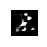

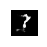

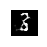

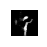

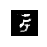

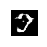

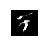

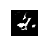

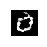

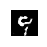

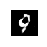

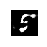

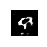

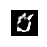

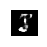

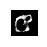

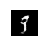

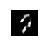

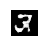

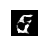

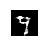

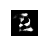

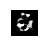

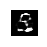

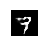

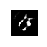

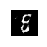

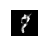

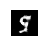

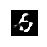

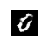

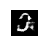

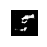

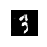

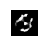

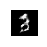

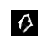

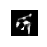

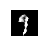

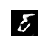

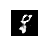

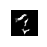

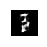

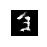

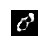

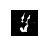

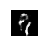

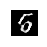

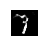

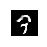

epoch:3500 g_loss:2.621389 d_loss:0.410569


In [ ]:
import tensorflow as tf


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    # return tf.random_normal(shape=size, stddev=xavier_stddev)
    return xavier_stddev


def conv(x, w, b, stride, name):
    with tf.variable_scope('conv'):
        tf.summary.histogram('weight', w)
        tf.summary.histogram('biases', b)
        return tf.nn.conv2d(x,
                           filter=w,
                           strides=[1, stride, stride, 1],
                           padding='SAME',
                           name=name) + b


def deconv(x, w, b, shape, stride, name):
    with tf.variable_scope('deconv'):
        tf.summary.histogram('weight', w)
        tf.summary.histogram('biases', b)
        return tf.nn.conv2d_transpose(x,
                                       filter=w,
                                       output_shape=shape,
                                       strides=[1, stride, stride, 1],
                                       padding='SAME',
                                       name=name) + b


def lrelu(x, alpha=0.2):
    with tf.variable_scope('leakyReLU'):
        return tf.maximum(x, alpha * x)


def discriminator(X, reuse=False):
    with tf.variable_scope('discriminator'):
        if reuse:
            tf.get_variable_scope().reuse_variables()

        K = 64
        M = 128
        N = 256

        W1 = tf.get_variable('D_W1', [4, 4, 1, K], initializer=tf.random_normal_initializer(stddev=0.1))
        B1 = tf.get_variable('D_B1', [K], initializer=tf.constant_initializer())
        W2 = tf.get_variable('D_W2', [4, 4, K, M], initializer=tf.random_normal_initializer(stddev=0.1))
        B2 = tf.get_variable('D_B2', [M], initializer=tf.constant_initializer())
        W3 = tf.get_variable('D_W3', [7*7*M, N], initializer=tf.random_normal_initializer(stddev=0.1))
        B3 = tf.get_variable('D_B3', [N], initializer=tf.constant_initializer())
        W4 = tf.get_variable('D_W4', [N, 1], initializer=tf.random_normal_initializer(stddev=0.1))
        B4 = tf.get_variable('D_B4', [1], initializer=tf.constant_initializer())

        X = tf.reshape(X, [-1, 28, 28, 1], 'reshape')

        conv1 = conv(X, W1, B1, stride=2, name='conv1')
        bn1 = tf.contrib.layers.batch_norm(conv1)
        conv2 = conv(tf.nn.dropout(lrelu(bn1), 0.4), W2, B2, stride=2, name='conv2')
        # conv2 = conv(lrelu(conv1), W2, B2, stride=2, name='conv2')

        bn2 = tf.contrib.layers.batch_norm(conv2)
        flat = tf.reshape(tf.nn.dropout(lrelu(bn2), 0.4), [-1, 7*7*M], name='flat')
        # flat = tf.reshape(lrelu(conv2), [-1, 7*7*M], name='flat')

        dense = lrelu(tf.matmul(flat, W3) + B3)
        logits = tf.matmul(dense, W4) + B4
        prob = tf.nn.sigmoid(logits)
        return prob, logits


def generator(X, batch_size=64):
    with tf.variable_scope('generator'):

        K = 256
        L = 128
        M = 64

        W1 = tf.get_variable('G_W1', [100, 7*7*K], initializer=tf.random_normal_initializer(stddev=0.1))
        B1 = tf.get_variable('G_B1', [7*7*K], initializer=tf.constant_initializer())

        W2 = tf.get_variable('G_W2', [4, 4, M, K], initializer=tf.random_normal_initializer(stddev=0.1))
        B2 = tf.get_variable('G_B2', [M], initializer=tf.constant_initializer())

        W3 = tf.get_variable('G_W3', [4, 4, 1, M], initializer=tf.random_normal_initializer(stddev=0.1))
        B3 = tf.get_variable('G_B3', [1], initializer=tf.constant_initializer())

        X = lrelu(tf.matmul(X, W1) + B1)
        X = tf.reshape(X, [batch_size, 7, 7, K])
        deconv1 = deconv(X, W2, B2, shape=[batch_size, 14, 14, M], stride=2, name='deconv1')
        bn1 = tf.contrib.layers.batch_norm(deconv1)
        deconv2 = deconv(tf.nn.dropout(lrelu(bn1), 0.4), W3, B3, shape=[batch_size, 28, 28, 1], stride=2, name='deconv2')

        XX = tf.reshape(deconv2, [-1, 28*28], 'reshape')

        return tf.nn.sigmoid(XX)

    
    
    
    
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import argparse


def read_data():
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)
    return mnist


def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        plt.show()
    return fig


logdir = "awesomelogs" 
batch_size = 64

tf.reset_default_graph()
mnist = read_data()

with tf.variable_scope('placeholder'):
    # Raw image
    X = tf.placeholder(tf.float32, [None, 784])
    tf.summary.image('raw image', tf.reshape(X, [-1, 28, 28, 1]), 3)
    # Noise
    z = tf.placeholder(tf.float32, [None, 100])  # noise
    tf.summary.histogram('Noise', z)

with tf.variable_scope('GAN'):
    G = generator(z, batch_size)

    D_real, D_real_logits = discriminator(X, reuse=False)
    D_fake, D_fake_logits = discriminator(G, reuse=True)
tf.summary.image('generated image', tf.reshape(G, [-1, 28, 28, 1]), 3)

with tf.variable_scope('Prediction'):
    tf.summary.histogram('real', D_real)
    tf.summary.histogram('fake', D_fake)

with tf.variable_scope('D_loss'):
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=D_real_logits, labels=tf.ones_like(D_real_logits)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))
    d_loss = d_loss_real + d_loss_fake

    tf.summary.scalar('d_loss_real', d_loss_real)
    tf.summary.scalar('d_loss_fake', d_loss_fake)
    tf.summary.scalar('d_loss', d_loss)

with tf.name_scope('G_loss'):
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                            (logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))
    tf.summary.scalar('g_loss', g_loss)

tvar = tf.trainable_variables()
dvar = [var for var in tvar if 'discriminator' in var.name]
gvar = [var for var in tvar if 'generator' in var.name]

with tf.name_scope('train'):
    d_train_step = tf.train.AdamOptimizer().minimize(d_loss, var_list=dvar)
    g_train_step = tf.train.AdamOptimizer().minimize(g_loss, var_list=gvar)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter('tmp/'+'gan_conv_'+logdir)
writer.add_graph(sess.graph)

num_img = 0
if not os.path.exists('output/'):
    os.makedirs('output/')

for i in range(100000):
    batch_X, _ = mnist.train.next_batch(batch_size)
    batch_noise = np.random.uniform(-1., 1., [batch_size, 100])

    if i % 500 == 0:
        samples = sess.run(G, feed_dict={z: np.random.uniform(-1., 1., [batch_size, 100])})
        fig = plot(samples)
        plt.savefig('output/%s.png' % str(num_img).zfill(3), bbox_inches='tight')
        num_img += 1
        plt.close(fig)

    _, d_loss_print = sess.run([d_train_step, d_loss],
                               feed_dict={X: batch_X, z: batch_noise})

    _, g_loss_print = sess.run([g_train_step, g_loss],
                               feed_dict={z: batch_noise})

    if i % 100 == 0:
        s = sess.run(merged_summary, feed_dict={X: batch_X, z: batch_noise})
        writer.add_summary(s, i)
        print('epoch:%d g_loss:%f d_loss:%f' % (i, g_loss_print, d_loss_print))






# Section 3: Deep q-learning with the OpenAI Gym (25 mins)
## Video 1:Exploring input and output of different games
## Video 2: Random search. Solving your first problem, and joining the leaderboard
## Video 3: Reinforcement learning explained: approximating the value function
## Video 4: Remembering your actions: adding a replay memory
## Video 5: Introduction to the Atari environment


## Video 1: Exploring input and output of different environments
To use the OpenAI gym you have to install the Gym environment. 

Use this URL: https://gym.openai.com

Environments can be found here: https://gym.openai.com/envs/

Let's start with importing the OpenAI gym

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

import gym

from matplotlib import animation
from JSAnimation.IPython_display import display_animation

# Create the environment and display the initial state
env = gym.make('CartPole-v0')
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
fig,ax = plt.subplots()
im = ax.imshow(firstframe) 




something about pressing random buttons.

In [ ]:


frames = []
observation, reward, done, info = env.step(action)
frame = env.render(mode = 'rgb_array')
im.set_data(frame)
frames.append(frame)
if done:
    env.reset()


In [ ]:
def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))

display_frames_as_gif(frames, filename_gif="manualplay.gif")


In [ ]:
%matplotlib notebook
from time import gmtime, strftime
import threading
import time

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display
import tensorflow as tf
import gym
from gym import wrappers
import random

from matplotlib import animation
from JSAnimation.IPython_display import display_animation

env = gym.make('CartPole-v0')
observation = env.reset()


## Value approximation

The goal of deep q learning is to estimate the reward you can get after a longer time for each action. 

Imagine you have this stick: 
-- image of a stick that is falling to the right

If you push the cart to the left, the stick will probably fall within a few frames. You would only get a few points. 

However, if you push the cart to the right, the stick will start to stand back up, and you will get a lot of points!

For each action we approximate the "value" that that action will bring. To do that we use an equation called the [Bellman Equation](https://en.wikipedia.org/wiki/Bellman_equation). In a nutshell this equation says you have to estimate the reward as: 
- The reward you get immediately
- A discount reward for every next timestep

It's like making an investment: sometimes an action that does not immediately give you a good reward will give you a reward later. 

For balancing a cartpole this is important, as for every action you get a reward, so any action except a dying action gives you a reward...

Although we could manually make a reward function (like: a higher reward is our pole has a low angle and no speed), let's keep using this reward function. 




### Environments that are difficult
Note that not every environment is now solvable with this algorithm. The cart that goes up the hill is kind of impossible with the current algorithm: you only get a reward if you reach the top...



## Atari games, and what to look for
There is also a huge list of Atari games you can try to solve. As training such a network takes a very long time (like: 24 hours) I won't give you the direct code for it in this video. I will give a lot of tips that can help you bring up this code. On my blog pinchofintelligence.com I did make a Jupyter notebook which gave me a trained network for the Atari set. 




Section 4: Timeseries and recurrent neural networks (20 mins)
Video 1: Dataset: predict stock price - simple RNN
Video 2: Unreasonable effectiveness of LSTMs
Video 3: Comparing LSTM to GRU cell


REMOVE THiS: Video 4: Recurrent neural networks in images and text


https://www.kaggle.com/camnugent/sandp500

Recurrent neural network: output is a combination of input AND previous state. 

Normal neural network only takes input, can't be used to do things like: predict something after a sentence, or predict the next frame in a video. 




Section 5: Learning from only one sample: simple siamese neural networks (15 mins)
Video 1: Discussion on methods with one sample (intro dataset)
Video 2: Defining a good loss function
Video 3: Training and testing your network. 

https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip

https://sorenbouma.github.io/blog/oneshot/


In [ ]:
import sys
import numpy as np
from scipy.misc import imread
#import dill as pickle
import os
import matplotlib.pyplot as plt
import argparse

data_path = "datasets/omniglot/"
basepath = os.path.join(data_path,'images_background')
valpath = os.path.join(data_path,'images_evaluation')
lang_dict = {}

def loadimgs(path,n=0):
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    #we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):

        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        #every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            if not os.path.isdir(letter_path):
                continue

            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            #edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

X,y,c=loadimgs(basepath)


# with open("train.pickle", "wb") as f:
#     pickle.dump((X,c),f)


X,y,c=loadimgs(valpath)
# with open("val.pickle", "wb") as f:
#     pickle.dump((X,c),f)

## Section idea: advanced classification problems 1: regularisation stuff
## Section idea: advanced classification problems 2: the siamese stuff
## Section idea: something with those layers that pass gradients faster!
